In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import collections
from torch.nn.parameter import Parameter

dataset = pd.read_csv(filepath_or_buffer='pretreatmented_data.csv', header=None)
FEATURES_INDEX = np.arange(50)
LABELS_INDEX = 50
BATCH_SIZE = 50
LOSS_THRESHOLD = 1e-7
dataset.head()

spam_dataset = dataset[dataset[LABELS_INDEX] == 1]
nonspam_dataset = dataset[dataset[LABELS_INDEX] == 0]
nonspam_dataset.reset_index(drop=True, inplace=True)
spam_dataset.reset_index(drop=True, inplace=True)
nonspam_dataset.tail()

rand_indxs_spam = np.arange(len(spam_dataset))
rand_indxs_nonspam = np.arange(len(nonspam_dataset))
np.random.shuffle(rand_indxs_nonspam)
np.random.shuffle(rand_indxs_spam)

spam_f_threshold = int(len(spam_dataset)*0.6)
spam_s_threshold = int(len(spam_dataset)*0.9)

nonspam_f_threshold = int(len(nonspam_dataset)*0.6)
nonspam_s_threshold = int(len(nonspam_dataset)*0.9)

learn_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[:spam_f_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[:nonspam_f_threshold]]])

valid_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_f_threshold:spam_s_threshold]],
                          nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_f_threshold:nonspam_s_threshold]]])

test_dataset = pd.concat([spam_dataset.iloc[rand_indxs_spam[spam_s_threshold:]],
                         nonspam_dataset.iloc[rand_indxs_nonspam[nonspam_s_threshold:]]])

print(len(learn_dataset), len(valid_dataset), len(test_dataset), len(learn_dataset)+len(valid_dataset)+len(test_dataset), len(dataset))

In [2]:
FEATURES_INDEX = [0, 1]
LABELS_INDEX = 2
LOSS_THRESHOLD = 1e-6

In [3]:
learn_dataset = pd.read_csv('learn_data.csv', index_col=0)
valid_dataset = pd.read_csv('valid_data.csv', index_col=0)
test_dataset = pd.read_csv('test_data.csv', index_col=0)
learn_dataset.head()

,0,1,2
0,0.980200,-0.735111,-0.573921
1,-1.758554,0.527610,2.068426
2,0.066156,0.404232,-0.447753
3,0.919834,-0.836112,-0.615778
4,-0.676431,-0.458955,0.800171


In [4]:
learn_dataset = np.array(learn_dataset)
valid_dataset = np.array(valid_dataset)
test_dataset = np.array(test_dataset)

In [5]:
learn_dataloader = DataLoader(learn_dataset, batch_size=1, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [6]:
tmp_learn = pd.DataFrame(learn_dataset)
tmp_learn.describe()

,0,1,2
count,4665.000000,4665.000000,4665.000000
mean,-0.011766,-0.000187,0.011096
std,0.991893,1.008940,1.001789
min,-2.204648,-2.902887,-1.937250
25%,-0.888991,-0.692825,-0.818483
50%,0.009958,0.009501,-0.197212
75%,0.786544,0.663561,0.827677
max,2.275708,2.699457,2.498951


In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(2, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 5)
        self.lin4 = nn.Linear(5, 1)
        self.f1 = nn.Tanh()
        self.f2 = nn.Tanh()
        self.f3 = nn.Tanh()

    def forward(self, x):
        self.h1 = self.f1(self.lin1(x))
        self.h2 = self.f2(self.lin2(self.h1))
        self.h3 = self.f3(self.lin3(self.h2))
        self.h4 = (self.lin4(self.h3))
        return self.h4

net = Net()
net

Net(
  (lin1): Linear(in_features=2, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=10, bias=True)
  (lin3): Linear(in_features=10, out_features=5, bias=True)
  (lin4): Linear(in_features=5, out_features=1, bias=True)
  (f1): Tanh()
  (f2): Tanh()
  (f3): Tanh()
)

In [8]:
criterion = nn.MSELoss(size_average=True)
optimizer = optim.Adam(net.parameters())

In [9]:
h_mean_collection_by_sigma = collections.defaultdict(list)
h_std_collection_by_sigma = collections.defaultdict(list)
g_mean_collection_by_sigma = collections.defaultdict(list)
g_std_collection_by_sigma = collections.defaultdict(list)

In [10]:
#функции инициализация весов
sigma_list = [0.0001, 0.01, 0.1, 0.5, 1, 2, 5, 10]
act_func_layers = ['tanh', 'tanh', 'sigmoid', 'sigmoid']

def init_weigths(layer):
    if(type(layer) == nn.Linear):
        if sigma == 'Xavier':
            nn.init.xavier_normal_(layer.weight.data, torch.nn.init.calculate_gain(tmp_act_fun.pop(0)))
            layer.bias.data.fill_(0.0)
        else:
            nn.init.normal_(layer.weight.data, mean=0, std=sigma)
            nn.init.normal_(layer.bias.data, mean=0, std=sigma)
            
index_list = [(1, 0), (2, 0), (3, 0)]

for epoch in range(50):
    #выход
    h_by_sigma = collections.defaultdict(list)
    #град
    g_by_sigma = collections.defaultdict(list)

    for sigma in sigma_list:
        tmp_act_fun = list(act_func_layers)
        net.apply(init_weigths)
        h_by_example = collections.defaultdict(list)
        g_by_example = collections.defaultdict(list)

        for learn_data in learn_dataloader:
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            optimizer.zero_grad()
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            for neuron in index_list:
                layer, num_neur = neuron
                if layer == 1:
                    h_by_example[neuron] += [float(net.h1[:, num_neur])]
                    g_by_example[neuron] += [float(net.lin1.weight.grad[num_neur, 0] / features[:, 0])]
                elif layer == 2:
                    h_by_example[neuron] += [float(net.h2[:, num_neur])]
                    g_by_example[neuron] += [float(net.lin2.weight.grad[num_neur, 0] / net.h1[:, 0])]
                elif layer == 3:
                    h_by_example[neuron] += [float(net.h3[:, num_neur])]
                    g_by_example[neuron] += [float(net.lin3.weight.grad[num_neur, 0] / net.h2[:, 0])]
        h_by_sigma[sigma] += [h_by_example]
        g_by_sigma[sigma] += [g_by_example]

    for neuron in index_list:
        for sigma in sigma_list:    
            h_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(h_by_sigma[sigma][0][neuron])]
            h_std_collection_by_sigma[(sigma, neuron)]  += [np.std(h_by_sigma[sigma][0][neuron])]
            g_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(g_by_sigma[sigma][0][neuron])]
            g_std_collection_by_sigma[(sigma, neuron)]  += [np.std(g_by_sigma[sigma][0][neuron])]

In [11]:
xavier_h_mean_collection_by_sigma = collections.defaultdict(list)
xavier_h_std_collection_by_sigma = collections.defaultdict(list)
xavier_g_mean_collection_by_sigma = collections.defaultdict(list)
xavier_g_std_collection_by_sigma = collections.defaultdict(list)

In [12]:
for epoch in range(50):
    #выход
    h_by_sigma = collections.defaultdict(list)
    #град
    g_by_sigma = collections.defaultdict(list)

    for sigma in ['Xavier']:
        tmp_act_fun = list(act_func_layers)
        net.apply(init_weigths)
        h_by_example = collections.defaultdict(list)
        g_by_example = collections.defaultdict(list)

        for learn_data in learn_dataloader:
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            optimizer.zero_grad()
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            for neuron in index_list:
                layer, num_neur = neuron
                if layer == 1:
                    h_by_example[neuron] += [float(net.h1[:, num_neur])]
                    g_by_example[neuron] += [float(net.lin1.weight.grad[num_neur, 0] / features[:, 0])]
                elif layer == 2:
                    h_by_example[neuron] += [float(net.h2[:, num_neur])]
                    g_by_example[neuron] += [float(net.lin2.weight.grad[num_neur, 0] / net.h1[:, 0])]
                elif layer == 3:
                    h_by_example[neuron] += [float(net.h3[:, num_neur])]
                    g_by_example[neuron] += [float(net.lin3.weight.grad[num_neur, 0] / net.h2[:, 0])]
        h_by_sigma[sigma] += [h_by_example]
        g_by_sigma[sigma] += [g_by_example]

    for neuron in index_list:
        for sigma in ['Xavier']:    
            xavier_h_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(h_by_sigma[sigma][0][neuron])]
            xavier_h_std_collection_by_sigma[(sigma, neuron)]  += [np.std(h_by_sigma[sigma][0][neuron])]
            xavier_g_mean_collection_by_sigma[(sigma, neuron)] += [np.mean(g_by_sigma[sigma][0][neuron])]
            xavier_g_std_collection_by_sigma[(sigma, neuron)]  += [np.std(g_by_sigma[sigma][0][neuron])]

0.5333355561557015
0.5686550844675666
0.45052656473726765


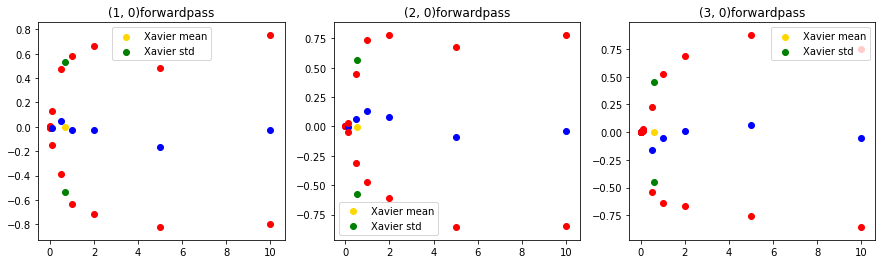

In [13]:
#прямой поток
plt.figure(figsize=(15,4))
plt.title('forwardpass')
for num, neuron in enumerate(index_list):
    plt.subplot(1, 3, num+1)
    for sigma in sigma_list:
        h_mean = np.mean(h_mean_collection_by_sigma[(sigma,neuron)])
        h_std = np.mean(h_std_collection_by_sigma[(sigma,neuron)])
        plt.scatter(sigma, h_mean, c='b')
        plt.scatter(sigma, h_mean+h_std, c='r')
        plt.scatter(sigma, h_mean-h_std, c='r')
    h_mean = np.mean(xavier_h_mean_collection_by_sigma[('Xavier',neuron)])
    h_std = np.mean(xavier_h_std_collection_by_sigma[('Xavier',neuron)])
    #подсчет сигма
    if neuron[0] == 1:
        xavier_sigma = (5/3) * (2/(10+2))**(1/2)
    elif neuron[0] == 2:
        xavier_sigma = (5/3) * (2/(10+10))**(1/2)
    elif neuron[0] == 3:
        xavier_sigma = (5/3) * (2/(10+5))**(1/2)
    plt.scatter(xavier_sigma, h_mean, c='gold', label = 'Xavier mean')
    plt.scatter(xavier_sigma, h_mean+h_std, c='green', label = 'Xavier std')
    plt.scatter(xavier_sigma, h_mean-h_std, c='green')
    print(h_std)
    plt.legend()
    plt.title(str(neuron)+'forwardpass')
plt.savefig('flow_forward.png', bbox_inches='tight')

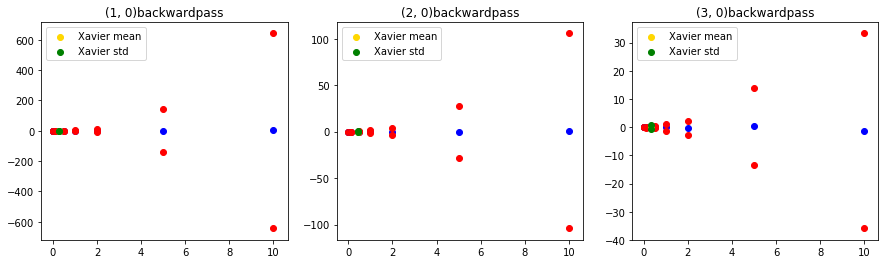

In [14]:
#обратный поток
plt.figure(figsize=(15,4))
plt.title('backwardpass')
for num, neuron in enumerate(index_list):
    plt.subplot(1, 3, num+1)
    for sigma in sigma_list:
        g_mean = np.mean(g_mean_collection_by_sigma[(sigma,neuron)])
        g_std = np.mean(g_std_collection_by_sigma[(sigma,neuron)])
        plt.scatter(sigma, g_mean, c='b')
        plt.scatter(sigma, g_mean+g_std, c='r')
        plt.scatter(sigma, g_mean-g_std, c='r')
    g_mean = np.mean(xavier_g_mean_collection_by_sigma[('Xavier',neuron)])
    g_std = np.mean(xavier_g_std_collection_by_sigma[('Xavier',neuron)])
    #подсчет сигма
    if neuron[0] == 1:
        sigma = (5/3) * (2/(20+50))**(1/2)
    elif neuron[0] == 2:
        sigma = (5/3) * (2/(20+10))**(1/2)
    elif neuron[0] == 3:
        sigma = (2/(10+10))**(1/2)
    plt.scatter(sigma, g_mean, c='gold', label = 'Xavier mean')
    plt.scatter(sigma, g_mean+g_std, c='g', label = 'Xavier std')
    plt.scatter(sigma, g_mean-g_std, c='g')
    plt.legend()
    plt.title(str(neuron)+'backwardpass')
plt.savefig('flow_backward.png', bbox_inches='tight')

In [16]:
#функции инициализация весов
#выход
hist_h_by_sigma = collections.defaultdict(list)
#град
hist_g_by_sigma = collections.defaultdict(list)

for sigma in [0.0001, 'Xavier', 10]:
    tmp_act_fun = list(act_func_layers)
    net.apply(init_weigths)
    h_by_example = collections.defaultdict(list)
    g_by_example = collections.defaultdict(list)

    for learn_data in learn_dataloader:
        features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
        features.requres_grad = True
        labels.requres_grad = True
        optimizer.zero_grad()
        outputs = net(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        for neuron in index_list:
            layer, num_neur = neuron
            if layer == 1:
                h_by_example[neuron] += [float(net.h1[:, num_neur])]
                g_by_example[neuron] += [float(net.lin1.weight.grad[num_neur, 0] / features[:, 0])]
            elif layer == 2:
                h_by_example[neuron] += [float(net.h2[:, num_neur])]
                g_by_example[neuron] += [float(net.lin2.weight.grad[num_neur, 0] / net.h1[:, 0])]
            elif layer == 3:
                h_by_example[neuron] += [float(net.h3[:, num_neur])]
                g_by_example[neuron] += [float(net.lin3.weight.grad[num_neur, 0] / net.h2[:, 0])]
    hist_h_by_sigma[sigma] += [h_by_example]
    hist_g_by_sigma[sigma] += [g_by_example]

In [17]:
hist_h_by_sigma

defaultdict(list,
            {0.0001: [defaultdict(list,
                          {(1, 0): [-1.5229634300339967e-05,
                            -0.00011897330841748044,
                            -0.00011609815555857494,
                            -5.62844070373103e-06,
                            -3.298599403933622e-05,
                            3.7210927985142916e-05,
                            6.1612590798176825e-06,
                            -3.8405152736231685e-05,
                            2.556062099756673e-05,
                            -0.0002485319273546338,
                            -2.169418439734727e-05,
                            -0.00025655151694081724,
                            0.00015266501577571034,
                            -2.3829041310818866e-05,
                            0.00013562236563302577,
                            2.970173954963684e-05,
                            7.549866131739691e-05,
                            -7.798185106366873e-

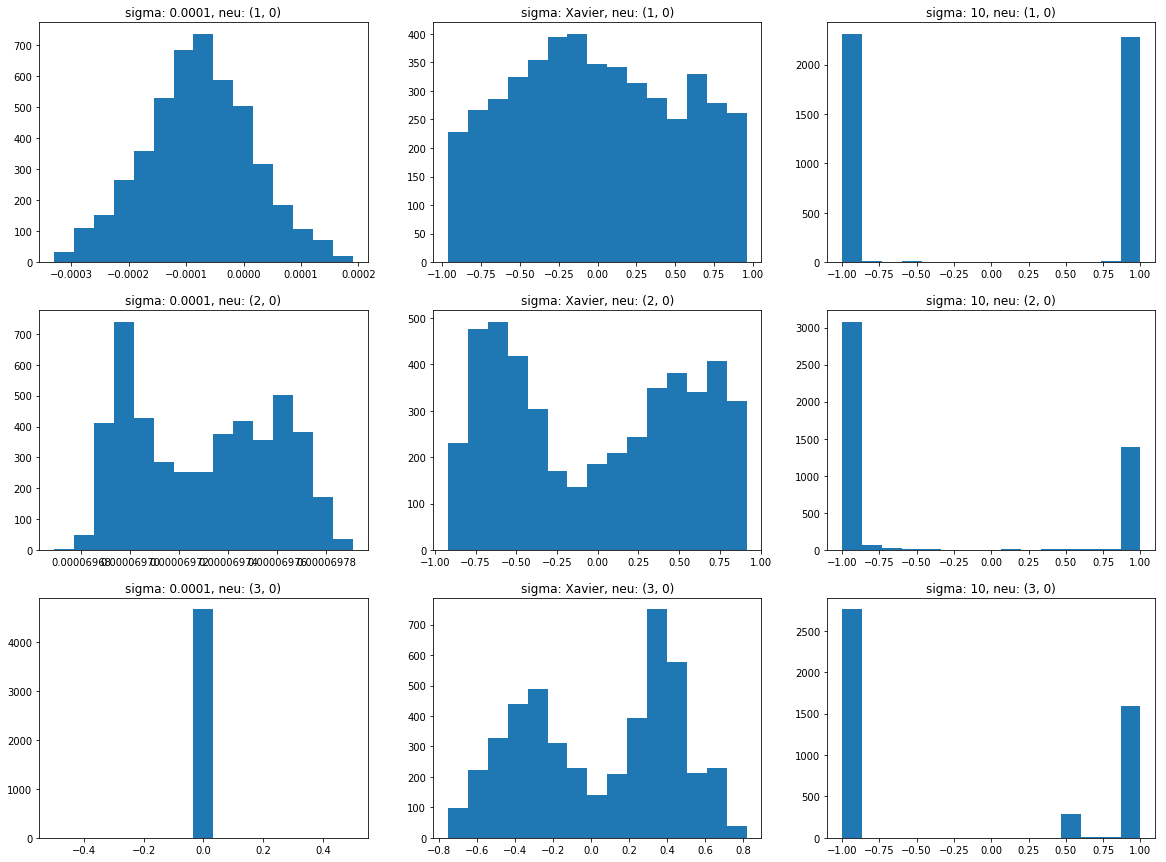

In [18]:
plt.figure(figsize=(20,15))
for num_neuron, neuron in enumerate(index_list):
    for num_sigma, sigma in enumerate([0.0001, 'Xavier', 10]):
        plt.subplot(3, 3, (num_neuron)*3+num_sigma+1)
        plt.title('sigma: '+str(sigma)+", neu: "+str(neuron))
        plt.hist(hist_h_by_sigma[sigma][0][neuron], bins=15)
plt.savefig('flow_histforw.png', bbox_inches='tight')

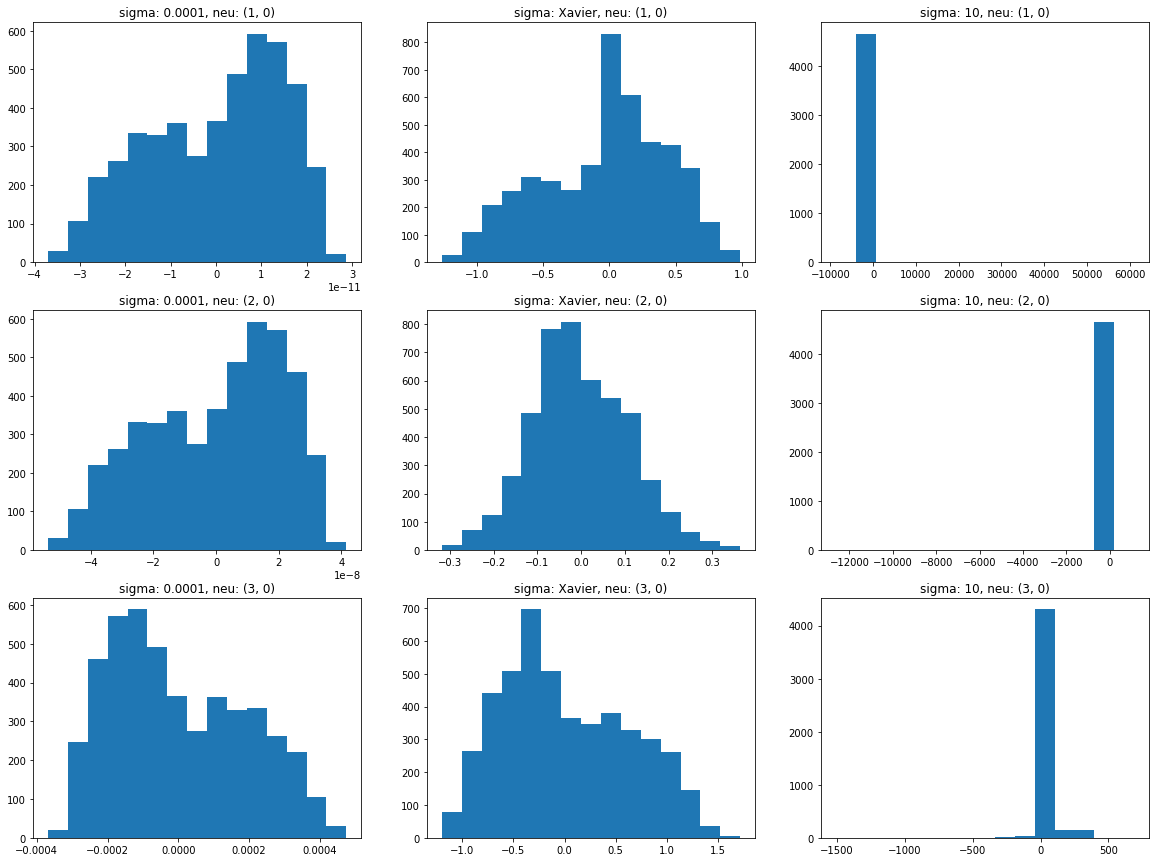

In [19]:
plt.figure(figsize=(20,15))
for num_neuron, neuron in enumerate(index_list):
    for num_sigma, sigma in enumerate([0.0001, 'Xavier', 10]):
        plt.subplot(3, 3, (num_neuron)*3+num_sigma+1)
        plt.title('sigma: '+str(sigma)+", neu: "+str(neuron))
        plt.hist(hist_g_by_sigma[sigma][0][neuron], bins=15)
plt.savefig('flow_histback.png', bbox_inches='tight')

In [23]:
lr=0.1

In [ ]:
%%time
learn_loss_by_sigma = []
valid_loss_by_sigma = []
test_loss_by_sigma = []
epoch_loss_by_sigma = []
sigma_for_learn = [0.0001, 'Xavier', 10]

for sigma in sigma_for_learn:
    optimizer = optim.SGD(net.parameters(), lr=0.001)
    
    tmp_act_fun = list(act_func_layers)
    net.apply(init_weigths)
    
    learn_epoch_loss = []
    valid_epoch_loss = []
    test_epoch_loss = []
    epoch_list = []
    
    for epoch in range(5*10**4):
        loss_acc = []
        for learn_data in learn_dataloader:
            optimizer.zero_grad()
            features, labels = learn_data[:, FEATURES_INDEX].float(), learn_data[:, LABELS_INDEX].float()
            features.requres_grad = True
            labels.requres_grad = True
            outputs = net(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc.append(float(loss.data))
        learn_epoch_loss.append(np.mean(loss_acc))
        
        #критерий останова
        if (epoch > 10) and\
        (abs(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2]) < LOSS_THRESHOLD):
            print(learn_epoch_loss[len(learn_epoch_loss) - 1] - learn_epoch_loss[len(learn_epoch_loss) - 2])
            print('lr: ', lr, ' breaked on epoch: ', epoch, '\n')
            break
            
        if epoch % 10 == 0:
            epoch_list.append(epoch)
            for valid_data in valid_dataloader:
                features, labels = valid_data[:, FEATURES_INDEX].float(), valid_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                valid_epoch_loss.append(float(loss.data))
                
            for test_data in valid_dataloader:
                features, labels = test_data[:, FEATURES_INDEX].float(), test_data[:, LABELS_INDEX].float()
                outputs = net(features).squeeze()
                loss = criterion(outputs, labels)
                test_epoch_loss.append(float(loss.data))
                
    learn_loss_by_sigma.append(learn_epoch_loss)
    valid_loss_by_sigma.append(valid_epoch_loss)
    test_loss_by_sigma.append(test_epoch_loss)
    epoch_loss_by_sigma.append(epoch_list)

1.8990808925423153e-11
lr:  0.1  breaked on epoch:  11 



In [22]:
#learn
for num, i in enumerate(lr_list):
    plt.plot(learn_loss_by_lr[num], label=str(i))
plt.title('learn loss')
plt.legend()
plt.savefig('nikflow_learn_loss.png', bbox_inches='tight')

NameError: name 'lr_list' is not defined

In [ ]:
#valid
for num, i in enumerate(lr_list):
    plt.plot(epoch_loss_by_lr[num], valid_loss_by_lr[num], label=str(i))
plt.title('valid loss')
plt.legend()
plt.savefig('nikflow_valid_loss.png', bbox_inches='tight')

In [ ]:
#test
for num, i in enumerate(lr_list):
    plt.plot(epoch_loss_by_lr[num], test_loss_by_lr[num], label=str(i))
plt.title('test loss')
plt.legend()
plt.savefig('nikflow_test_loss.png', bbox_inches='tight')

In [ ]:
for i in range(5):
    print((learn_loss_by_lr[i])[-1])

In [ ]:
for i in range(5):
    print((test_loss_by_lr[i])[-1])